# CSII 2025 Exercise 04: State Feedback with Luenberger Observer

© 2025 ETH Zurich, Aya Abrini, Livia Fischer, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Reference:
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- Karl J. Astrom and Richard M. Murray 23 Jul 2019


To start, run the following cell to install the necessary modules and import the libraries.


In [ ]:
!pip install numpy matplotlib scipy ipywidgets
!pip install control

In [ ]:
# Import necessary libraries
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt
# Set up matplotlib for inline plotting
%matplotlib inline
# This ensures plots are displayed directly in the notebook
from scipy.linalg import solve_continuous_are  # For solving the Riccati equation (used in Kalman filter design)
from scipy.linalg import solve_discrete_are
from scipy.signal import place_poles
from scipy.integrate import solve_ivp  # For solving differential equations
from ipywidgets import interact, FloatSlider, widgets  # For interactive sliders
import control as ct

# Exercise 1: Luenberger observer





### System Description: Linear Time-Invariant (LTI) System

This code simulates a **linear time-invariant (LTI) system** and plots its states over time. The system is given in the state-space form: $$
\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2 \end{bmatrix} = \begin{bmatrix}-1.1 & 0.4 \\ 0.25 & 0 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + \begin{bmatrix}1 \\ 0 \end{bmatrix} u,
$$

$$y = \begin{bmatrix} -1 & 0.8 \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix}. $$
This first plot shows the evolution of the states. This means it solves the ODE exactly to get to an solution for $x_1(t)$ and $x_2(t)$.

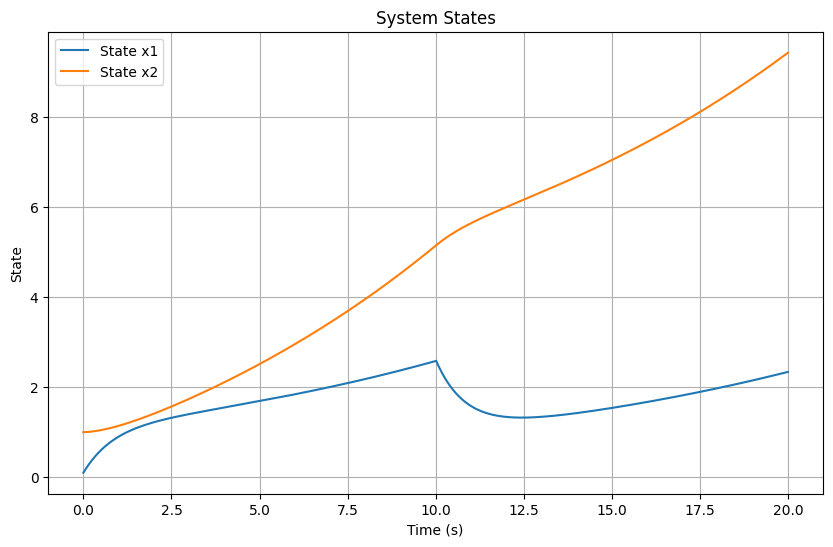

In [ ]:
# Define system matrices
A = np.array([[-1.1, 0.4], [0.25, 0]])
B = np.array([[1], [0]])
C = np.array([[-1, 0.8]])

# Initial state
x0 = np.array([[0.1], [1]])

# Time parameters
dt = 0.01
t_end = 20
t = np.arange(0, t_end, dt)

# Input signal (step input)
u = np.ones_like(t)
u[t > 10] = -1  # Change input at t = 10

# Simulate the system
x = np.zeros((2, len(t)))
x[:, 0] = x0.flatten()

for i in range(1, len(t)):
    x[:, i] = x[:, i-1] + dt * (A @ x[:, i-1] + (B * u[i-1]).flatten())

# Plot the system states
plt.figure(figsize=(10, 6))
plt.plot(t, x[0, :], label='State x1')
plt.plot(t, x[1, :], label='State x2')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.title('System States')
plt.legend()
plt.grid()
plt.show()

This code computes the **observer gain \( L \)** using pole placement. The observer is designed to estimate the system's state by placing the observer's poles at specific locations in the complex plane. The desired poles are chosen to ensure fast and stable convergence of the observer's estimate to the true state. To start we set the desired poles at $-1+j, -1 -j$.

In [ ]:
# Desired observer poles
desired_poles = np.array([-1 + 1j, -1 - 1j])  # Desired poles for the observer

# TODO: Compute the observer gain L using pole placement
# Hint: Use the function `place_poles` to compute the gain matrix L.
# The function requires the transpose of A and C, and the desired poles.
L = place_poles(A.T, C.T, desired_poles).gain_matrix.T

print("Observer gain L:")
print(L)

Observer gain L:
[[1.95  ]
 [3.5625]]


### Observer Simulation

This code simulates the **Luenberger observer**, which estimates the system's state using the system model and measurements. The observer starts with an initial estimate of zero and updates its estimate over time using the innovation term $y - \hat{y} $, where:
- $y$: Real measurement from the system.
- $\hat{y}$: Estimated measurement from the observer.

The observer's estimate is compared to the true state, and both are plotted over time.
From the plot you can see that the estimation converges over time to the true state. The inital error we get because we don't know the actual initial condition. over the time the system will converge if it is stable.

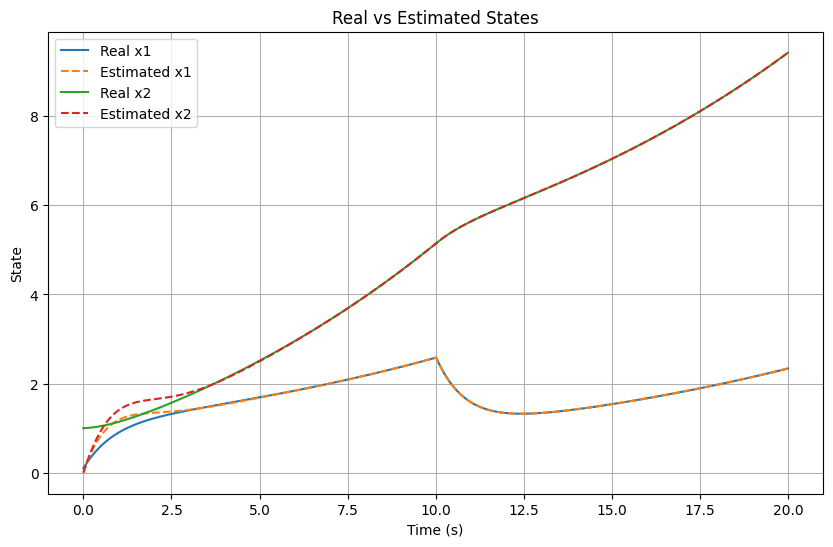

In [ ]:
# Initial state estimate
x_hat0 = np.array([[0], [0]])  # Assume initial estimate is zero
x_hat = np.zeros((2, len(t)))
x_hat[:, 0] = x_hat0.flatten()

# Simulate the observer
for i in range(1, len(t)):
    y = C @ x[:, i-1]  # Real measurement
    y_hat = C @ x_hat[:, i-1]  # Estimated measurement
    # TODO: Update the observer's state estimate
    # x_hat(t + dt) = x_hat(t) + dt * (A @ x_hat(t) + B @ u(t) + L @ (y - y_hat))
    x_hat[:, i] = x_hat[:, i-1] + dt * (A @ x_hat[:, i-1] + (B * u[i-1]).flatten() + L @ (y - y_hat))

# Plot the real and estimated states
plt.figure(figsize=(10, 6))
plt.plot(t, x[0, :], label='Real x1')
plt.plot(t, x_hat[0, :], '--', label='Estimated x1')
plt.plot(t, x[1, :], label='Real x2')
plt.plot(t, x_hat[1, :], '--', label='Estimated x2')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.title('Real vs Estimated States')
plt.legend()
plt.grid()
plt.show()

This code provides an interactive tool to explore the effect of observer pole placement on a Luenberger observer. By adjusting the real and imaginary parts of the desired poles using sliders, you can see how the observer's performance changes.

In [ ]:
from scipy.integrate import solve_ivp
# Interactive function to change observer poles
def simulate_observer(real_part, imag_part):
    # Desired observer poles
    desired_poles = np.array([real_part + imag_part * 1j, real_part - imag_part * 1j])

    # Compute the observer gain L
    L = place_poles(A.T, C.T, desired_poles).gain_matrix.T

    # Simulate the observer
    x_hat = np.zeros((2, len(t)))
    x_hat[:, 0] = x_hat0.flatten()

    for i in range(1, len(t)):
        y = C @ x[:, i-1]
        y_hat = C @ x_hat[:, i-1]
        # TODO: Update the observer's state estimate (same as before)
        x_hat[:, i] = x_hat[:, i-1] + dt * (A @ x_hat[:, i-1] + (B * u[i-1]).flatten() + L @ (y - y_hat))

    # Plot the real and estimated states
    plt.figure(figsize=(10, 6))
    plt.plot(t, x[0, :], label='Real x1')
    plt.plot(t, x_hat[0, :], '--', label=f'Estimated x1 (poles: {desired_poles})')
    plt.plot(t, x[1, :], label='Real x2')
    plt.plot(t, x_hat[1, :], '--', label=f'Estimated x2 (poles: {desired_poles})')
    plt.xlabel('Time (s)')
    plt.ylabel('State')
    plt.title('Real vs Estimated States')
    plt.legend()
    plt.grid()
    plt.show()

# Interactive widget
interact(simulate_observer,
         real_part=FloatSlider(value=-1, min=-5, max=3, step=0.5, description='Real Part:'),
         imag_part=FloatSlider(value=1, min=0, max=5, step=0.5, description='Imaginary Part:'));

interactive(children=(FloatSlider(value=-1.0, description='Real Part:', max=3.0, min=-5.0, step=0.5), FloatSli…

Feel free to play with the values. Try and find poles for wich the system converges and diverges.
What is your conclusion for different selections?

## Exercise 2: Kalman filter

### System Description: Drone Altitude Control  

This system models a **drone trying to maintain a desired altitude**. The drone's dynamics are described by:  

#### **States:**  
- \( x_1 \): Altitude (position) of the drone.  
- \( x_2 \): Vertical velocity of the drone.  

#### **Forces:**  
- **Thrust \( u \)**: Control input from the drone's propellers.  
- **Air Resistance**: Modeled as \( -k x_1 \).  
- **Damping**: Modeled as \( -c x_2 \).  

#### **State-Space Equations:**  
$$
\dot{x} = A x + B u
$$
$$
y = C x
$$  
where:  
- \( A \): State matrix (system dynamics).  
- \( B \): Input matrix (effect of thrust).  
- \( C \): Output matrix (measures altitude).  

The goal is to estimate the drone's altitude and velocity using a **Kalman filter** in the presence of process and measurement noise.

In [ ]:
# System parameters
m = 1.0  # Mass of the drone (kg)
k = 0.5  # Spring constant (air resistance)
c = 0.2  # Damping coefficient

# State-space matrices (continuous-time)
A_cont = np.array([[0, 1], [-k/m, -c/m]])
B_cont = np.array([[0], [1/m]])
C = np.array([[1, 0]])  # Measure altitude only

# Discretize the system (assuming a small time step dt)
dt = 0.1  # Time step
A = np.eye(2) + A_cont * dt  # Discrete-time state matrix
B = B_cont * dt  # Discrete-time input matrix


...

In [ ]:
def design_kalman_filter(A, C, Q, R):
    """Design Kalman filter gain L_kf."""
    # TODO: Solve the discrete-time algebraic Riccati equation (DARE) to find P
    # Hint: Use the function `solve_discrete_are` with A.T, C.T, Q, and R
    P = solve_discrete_are(A.T, C.T, Q, R)
    L_kf = P @ C.T @ np.linalg.inv(C @ P @ C.T + R)
    return L_kf

# Noise covariance matrices
Q = np.eye(2) * 0.1  # Process noise covariance (model inaccuracies)
R = np.eye(1) * 1.0  # Measurement noise covariance (sensor inaccuracies)

# Kalman filter gain
L_kf = design_kalman_filter(A, C, Q, R)
print("Kalman Filter Gain L_kf:", L_kf)

Kalman Filter Gain L_kf: [[0.31489289]
 [0.17288439]]


### Drone Altitude Estimation with Kalman Filter

This code simulates a **drone's altitude control system** using a Kalman filter to estimate the altitude in the presence of process and measurement noise. The system is subject to:
- **Process Noise**: Represents uncertainties in the system model (e.g., wind gusts).
- **Measurement Noise**: Represents uncertainties in the sensor measurements (e.g., altitude sensor errors).

The Kalman filter dynamically updates its estimate of the drone's altitude by balancing trust in the system model and the sensor measurements. The true altitude and the Kalman filter's estimate are plotted over time for comparison.

In [ ]:
def simulate_system(noise=False, T=10, process_noise=0.1, measurement_noise=1.0):
    """Simulate the system with Kalman filter."""
    # Time parameters
    num_steps = int(T / dt)
    t = np.arange(0, T, dt)

    # Input function (thrust profile)
    def u(k):
        return 1.0 if k * dt < 5 else 0.0  # Apply thrust for 5 seconds

    # Initial conditions (as 2D column vectors)
    x = np.array([[0.0], [0.0]])  # True initial state (altitude and velocity)
    x_hat = np.array([[0.0], [0.0]])  # Observer initial estimate

    # Adjust noise covariance matrices
    Q = np.eye(2) * process_noise  # Process noise covariance (2x2)
    R = np.eye(1) * measurement_noise  # Measurement noise covariance (1x1)

    # Arrays to store results
    x_history = np.zeros((2, num_steps))
    x_hat_history = np.zeros((2, num_steps))

    # Simulate the system
    for k in range(num_steps):
        # Process noise (if enabled)
        w = np.random.multivariate_normal([0, 0], Q).reshape(-1, 1) if noise else np.zeros((2, 1))

        # Sensor noise (if enabled)
        n = np.random.normal(0, np.sqrt(R[0,0])) if noise else 0

        # True system dynamics
        x = A @ x + B * u(k) + w  # All terms are (2x1)
        y = C @ x + n  # Noisy measurement (scalar)

        # Kalman filter
        innovation = y - C @ x_hat  # Innovation term (scalar)
        x_hat = A @ x_hat + B * u(k) + L_kf * innovation  # L_kf * innovation is (2x1)

        # Store results
        x_history[:, k] = x.flatten()
        x_hat_history[:, k] = x_hat.flatten()

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(t, x_history[0, :], 'k', label='True Altitude')
    plt.plot(t, x_hat_history[0, :], 'b--', label='Kalman Filter Estimate')
    plt.xlabel('Time (s)')
    plt.ylabel('Altitude (m)')
    plt.title('Drone Altitude Estimation with Kalman Filter')
    plt.legend()
    plt.grid(True)
    plt.show()

Find the solution on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/59ad007bfeabdaed54f2b620ccb969f37c56104f/src/cs2solutions/decomp.py#L174-L203).

In [ ]:
# Interactive widget for noise and simulation time
@interact(
    process_noise=FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='Process Noise (Q):'),
    measurement_noise=FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Measurement Noise (R):'),
    T=FloatSlider(value=10, min=5, max=20, step=1, description='Simulation Time:')
)
def interactive_simulation(process_noise, measurement_noise, T):
    """Interactive simulation with noise and time controls."""
    simulate_system(noise=True, T=T, process_noise=process_noise, measurement_noise=measurement_noise)

interactive(children=(FloatSlider(value=0.1, description='Process Noise (Q):', max=1.0, min=0.01, step=0.01), …

#Exercise 3: LQE

...

In [ ]:

# Define system parameters
dt = 0.1  # Time step
A = 1  # State transition matrix (simple 1x1 system)
B = 1  # Control input matrix
C = 1  # Measurement matrix
u = 0  # Control input (can be set to zero for simplicity)

# Initial state
x_true = 0  # Initial true state
x_est = 0  # Initial estimate

# Simulation length
T = 50  # Number of time steps

# Kalman Filter setup
def kalman_filter(Q_process_noise, R_measurement_noise, Q_weight, R_weight):
    global x_true, x_est

    # Process and measurement noise
    process_noise = np.random.normal(0, np.sqrt(Q_process_noise), T)
    measurement_noise = np.random.normal(0, np.sqrt(R_measurement_noise), T)

    # State vectors
    x_true_vals = np.zeros(T)
    x_measured_vals = np.zeros(T)
    x_est_vals = np.zeros(T)

    # Initial conditions
    x_true_vals[0] = x_true
    x_measured_vals[0] = x_true + np.random.normal(0, np.sqrt(R_measurement_noise))  # Initial measurement
    x_est_vals[0] = x_est

    # Covariance matrices
    P = 1  # Initial estimation error covariance
    P_est = P

    # Kalman gain
    K = 0

    # Simulation loop
    for t in range(1, T):
        # True state (with process noise)
        x_true = A * x_true + B * u + process_noise[t]
        x_measured = C * x_true + measurement_noise[t]

        # Prediction step
        x_pred = A * x_est  # Predicted state estimate
        P_pred = A * P_est * A + Q_process_noise  # Predicted error covariance

        # Kalman Gain (weighted by Q_weight and R_weight)
        K = (P_pred * C) / (C * P_pred * C + R_measurement_noise)
        K = K * Q_weight / (K * Q_weight + R_weight)  # Adjust based on weights

        # Correction step
        x_est = x_pred + K * (x_measured - C * x_pred)
        P_est = (1 - K * C) * P_pred  # Updated error covariance

        # Store values
        x_true_vals[t] = x_true
        x_measured_vals[t] = x_measured
        x_est_vals[t] = x_est

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x_true_vals, label="True State", color="b")
    plt.plot(x_measured_vals, label="Measured Value", color="g", linestyle="--")
    plt.plot(x_est_vals, label="Estimated State", color="r")
    plt.title(f"LQE Estimation")
    plt.xlabel("Time Step")
    plt.ylabel("State Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive sliders for the four parameters
interact(kalman_filter,
         Q_process_noise=widgets.FloatSlider(value=0.1, min=0.01, max=2, step=0.01, description='Process Noise Q:'),
         R_measurement_noise=widgets.FloatSlider(value=0.1, min=0.01, max=2, step=0.01, description='Measurement Noise R:'),
         Q_weight=widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Q'),
         R_weight=widgets.FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='R'))


interactive(children=(FloatSlider(value=0.1, description='Process Noise Q:', max=2.0, min=0.01, step=0.01), Fl…

<function __main__.kalman_filter(Q_process_noise, R_measurement_noise, Q_weight, R_weight)>

...

#Exercise 4: Kalman Filter

...

In [ ]:
# Simulated system parameters
dt = 1.0  # Time step
A = np.array([[1, dt], [0, 1]])  # State transition model
H = np.array([[1, 0]])  # Observation model

# Interactive function
def kalman_filter(process_noise, measurement_noise):
    np.random.seed(42)  # For reproducibility

    # True state initialization
    x_true = np.array([[0], [1]])  # Initial position = 0, velocity = 1

    # Kalman filter initialization
    x_est = np.array([[0], [0]])  # Initial estimate
    P = np.eye(2)  # Initial uncertainty
    Q = np.eye(2) * process_noise  # Process noise covariance
    R = np.array([[measurement_noise]])  # Measurement noise covariance

    # Simulation
    num_steps = 50
    x_traj = []  # True trajectory
    x_est_traj = []  # Estimated trajectory
    measurements = []
    kalman_gains = []  # Store Kalman Gains

    for _ in range(num_steps):
        # Simulate true motion
        x_true = A @ x_true + np.random.multivariate_normal([0, 0], Q).reshape(-1, 1)
        z = H @ x_true + np.random.normal(0, measurement_noise)  # Measurement

        # Prediction step
        x_pred = A @ x_est
        P_pred = A @ P @ A.T + Q

        # Update step
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)  # Kalman Gain
        x_est = x_pred + K @ (z - H @ x_pred)
        P = (np.eye(2) - K @ H) @ P_pred

        # Store data
        x_traj.append(x_true[0, 0])
        x_est_traj.append(x_est[0, 0])
        measurements.append(z[0, 0])
        kalman_gains.append(K[0, 0])

    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    ax[0].plot(x_traj, label='True Position', linestyle='dashed')
    ax[0].plot(measurements, 'rx', label='Measurements')
    ax[0].plot(x_est_traj, label='Kalman Estimate')
    ax[0].legend()
    ax[0].set_xlabel("Time Step")
    ax[0].set_ylabel("Position")
    ax[0].set_title("Kalman Filter: 1D Object Tracking")

    ax[1].plot(kalman_gains, label='Observer Gain (L)', color='green')
    ax[1].legend()
    ax[1].set_xlabel("Time Step")
    ax[1].set_ylabel("Observer Gain")
    ax[1].set_title("Observer Gain Over Time")

    plt.tight_layout()
    plt.show()

# Create interactive widgets
widgets.interact(
    kalman_filter,
    process_noise=widgets.FloatLogSlider(value=0.1, base=10, min=-3, max=2, step=0.1, description='Process Noise'),
    measurement_noise=widgets.FloatLogSlider(value=1.0, base=10, min=-3, max=1, step=0.1, description='Measurement Noise')
);

interactive(children=(FloatLogSlider(value=0.1, description='Process Noise', max=2.0, min=-3.0), FloatLogSlide…

# Exercise 4: Duality of estimation and control

We have learned about the duality of estimation and control. The duality between estimation and control arises from the fact that accurate estimation of the system state is often essential for effective control. Conversely, the control actions applied to the system affect the measurements obtained from sensors, which in turn impact the accuracy of state estimation.\
We don't want to have seperate Ackermann's formula implementations for the both problems. We want to use one implementation. How would you use the `acker` function from the `control` library for calculating the gain of the estimator? Instead of using the `control` library you could also use your implementation from the state feedback exercise.

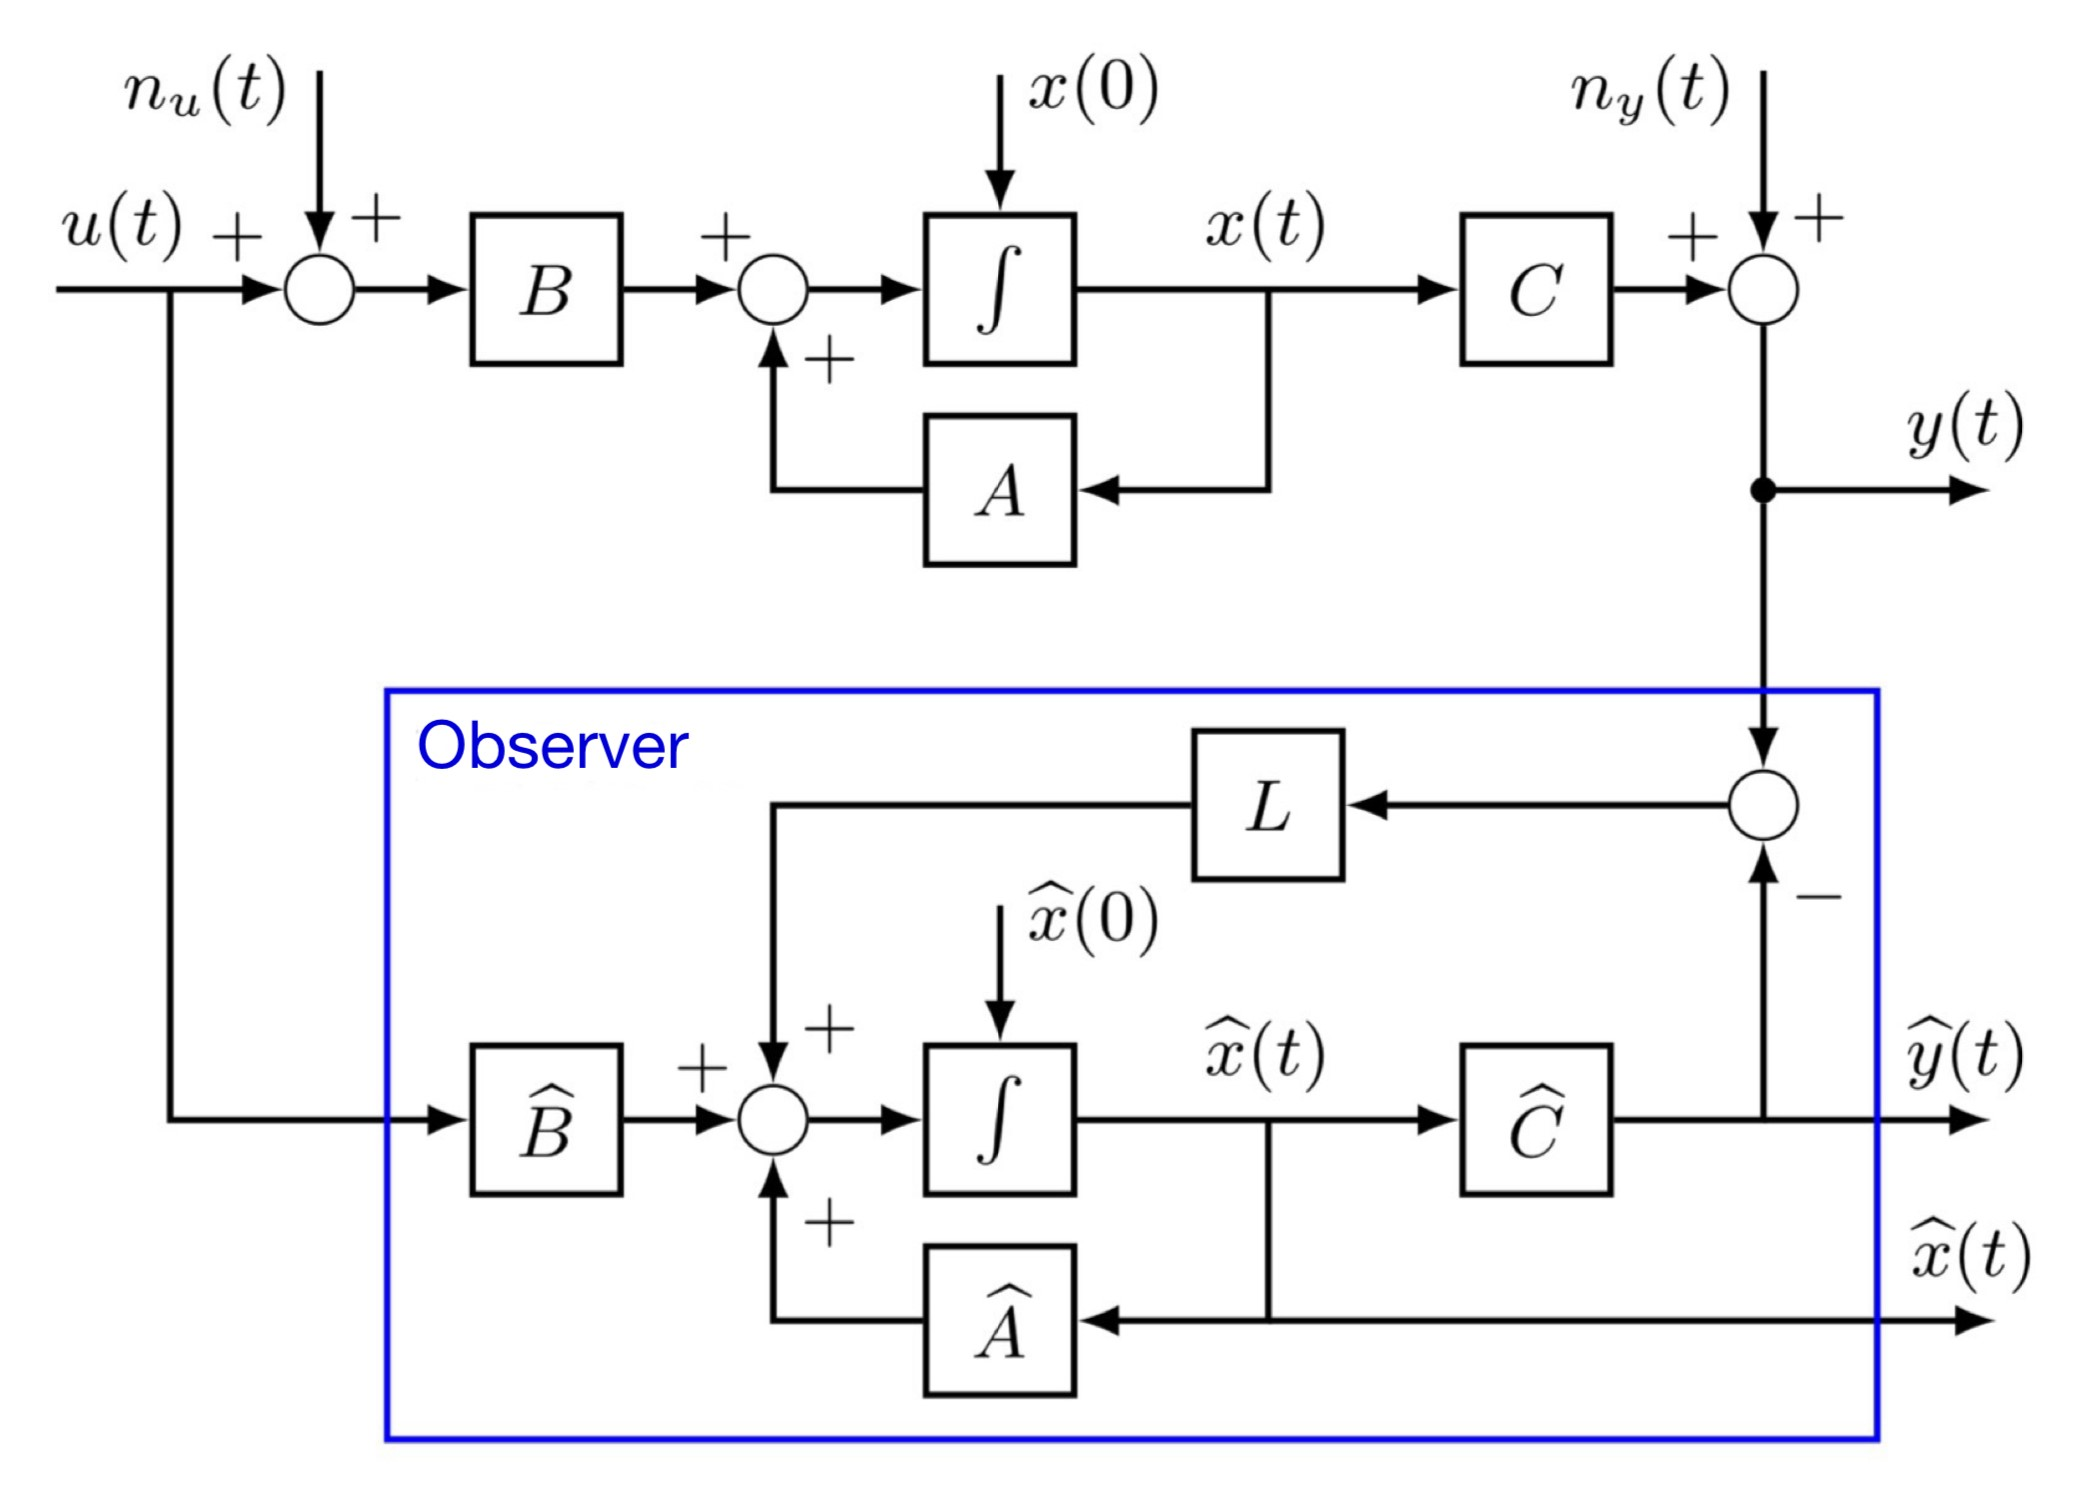

In [ ]:
# Use poles_test to test your implemnation against the solution
poles_test = [-2, -3]

In [ ]:
# Write your code here. Something like:
# L = ct.acker(matrix, matrix, poles_test)
L_dual = ct.acker(A, C, poles_test)

## Solution Exercise 3: Duality of estimation and control

In [ ]:
#@title
L_sol_dual = ct.acker(A.T, C.T, poles_test).T

AttributeError: 'int' object has no attribute 'T'

##Test your implementation here:

In [ ]:
if np.array_equal(L_dual, L_sol_dual):
  print('Your Implementation is correct!')
  print(f'Solution: {L_sol_dual}')
else:
  print(f'Your implementation: {L_dual}')
  print(f'Solution: {L_sol_dual}')

## Simulation
In the next cell we code the whole state feedback control loop as an input output system. Take a look and try to understand the code.

In [ ]:
def state_noise(u: np.array) -> np.array:
    y = u[1] + u[0]
    theta = u[2] + u[0]
    return np.array([y, theta])

def state_feedback_controller(r: np.array, K: np.array, kr: np.array) -> np.array:
    u = -K @ r[1:] + kr * r[0]
    return u

def plant(x: np.array, u: np.array, A: np.array, B: np.array) -> np.array:
    xdot = A @ x + B @ u
    return xdot

def plant_out(x: np.array, u: np.array) -> np.array:
    y = x
    return y

def estimator(x: np.array, u: np.array, A: np.array, B: np.array,
        C: np.array, D: np.array, L: np.array) -> np.array:
  x = np.expand_dims(x, axis=1)
  xdot = (A - L @ C) @ x + B * u[0]  + L*u[1]
  return xdot


def estimator_out(x: np.array, u: np.array) -> np.array:
    return x

def get_closed_loop_io_system(io_system_params: dict) -> ct.NonlinearIOSystem:
  sys_n = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_noise(u),
      inputs=('n', 'y', 'theta'),
      outputs=('yn', 'thetan'),
      params=None,
      name='noise')

  sys_cont = ct.NonlinearIOSystem(
      None,
      lambda t, x, u, params: state_feedback_controller(u, params['K'],
                                                        params['kr']),
      inputs=('reference','x1', 'x2'),
      outputs=('control'),
      params=io_system_params,
      name='controller')


  sys_est = ct.NonlinearIOSystem(
    lambda t, x, u, params: estimator(x, u, params['A'], params['B'],
                                      params['C'], params['D'], params['L']),
    lambda t, x, u, params: estimator_out(x, u),
    inputs=('control', 'y', 'theta'),
    outputs=('y', 'theta'),
      states=('x1', 'x2'),
    params=io_system_params,
    name='estimator')

  sys_dyn = ct.NonlinearIOSystem(
      lambda t, x, u, params: plant(x, u, params['A'], params['B']),
      lambda t, x, u, params: plant_out(x, u),
      inputs=('control',),
      outputs=('y', 'theta'),
      states=('x1', 'x2'),
      params=io_system_params,
      name='plant')


  io_closed = ct.interconnect(
    [sys_dyn, sys_cont, sys_n, sys_est],       # systems
    connections=[
      ['plant.control', 'controller.control'],
      ['controller.x1', 'estimator.y'],
      ['controller.x2', 'estimator.theta'],
      ['noise.theta', 'plant.theta'],
      ['noise.y', 'plant.y'],
      ['estimator.control', 'controller.control'],
      ['estimator.y', 'noise.yn'],
      ['estimator.theta', 'noise.thetan']
    ],
    inplist=['controller.reference', 'noise.n'],
    outlist=['plant.y', 'controller.control']
  )

  return io_closed

def simulate(A: np.array, B: np.array, C: np.array,
            t: np.array, U: np.array, X0: List,
            poles: List, poles_observer: List) -> Tuple[np.array, np.array]:
            K, kr, clsys = place_poles_Ackermann(A=A, B=B, C=C, D=0,
                            poles=poles)
            L = ct.acker(A.T, C.T, poles_observer).T
            io_system_params = {'A': A, 'B': B, 'C': C, 'D': 0, 'K': K, 'kr': kr, 'L': L}
            io_closed = get_closed_loop_io_system(io_system_params)

            tp, yp, up = ct.input_output_response(io_closed, T=t, U=U, X0=X0, return_x=True)

            return tp, yp


Now we would like to simulate the system with a state feedback controller and a Luenberger observer. In the next cell you can choose your controller poles in `poles_controller`, your observer poles in `poles_observer` and your initial state `x0`. The first two elements of `x0` are the `y` and `theta` initial states of the plant (true initial state) and the last two elments are the `y` and `theta` initial states of the estimator. Try to change the initial guess of your estimator and choose the right relative poles between controller and observer.\
The rule of thumb commonly used is to place the observer poles approximately three to five times faster than the controller poles. This ensures that the observer responds quickly enough to provide accurate state estimates without introducing excessive noise or errors into the control loop.

In [ ]:
poles_controller = [-0.1, -0.1] # Try to change it
poles_observer = [-1, -1] # Try to change it
x0 = [0.2, 0.1, 0.0, 0.0] # Try to change it
tp, yp = simulate(A, B, C, t, U, x0, poles_controller, poles_observer)
plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy,
            yp[0], yp[1])

## Poles Comparison

In this section we will do the same as before, just comparing different poles against each other. We will compare aggressive poles, less aggressive poles and complex conjugate poles for the observer. We will keep the controller poles constant.

In [ ]:
poles_controller = [-0.1, -0.1] # Try to change it
poles_aggressive = [-10, -10] # Try to change it
poles_easy = [-0.1, -0.1,] # Try to change it
poles_complex_1 = [-1+2j, -1-2j] # Try to change it
poles_complex_2 = [-1+0.1j, -1-0.1j] # Try to change it
x0 = [0.2, 0.1, 0.0, 0.0]

pole_list = [poles_aggressive, poles_easy, poles_complex_1, poles_complex_2]
t_list = []
y_list = []
u_list = []
for p in pole_list:
  tp, yp = simulate(A, B, C, t, U, x0, poles_controller, p)
  t_list.append(tp)
  y_list.append(yp[0])
  u_list.append(yp[1])

plot_track_multiple_controller2(y_curvy[0], y_curvy[1], x_curvy[2], t_list,
                               w_curvy, y_list, u_list)


## Initial state comparison

In this section we will do the same as before, just comparing different initial states . We will keept the poles and the initial guess of the estimator constant but change the initial position of the CS2-Bot.

In [ ]:
poles_controller = [-0.1, -0.1]
poles_observer = [-1, -1]

x01 = [0.3, 0.3, 0.0, 0.0] # Try to change it
x02 = [0.2, 0.2, 0.0, 0.0] # Try to change it
x03 = [-0.1, -0.1, 0.0, 0.0] # Try to change it
x04 = [-0.2, 0.2, 0.0, 0.0] # Try to change it
x05 = [0.0, 0.0, 0.0, 0.0] # Try to change it

x0_list = [x01, x02, x03, x04, x05]
t_list = []
y_list = []
u_list = []
for x0 in x0_list:
  tp, yp = simulate(A, B, C, t, U, x0, poles_controller, poles_observer)
  t_list.append(tp)
  y_list.append(yp[0])
  u_list.append(yp[1])

plot_track_multiple_controller2(y_curvy[0], y_curvy[1], x_curvy[2], t_list,
                               w_curvy, y_list, u_list)


# Outlook
- Change the tracks and create your own reference track
- Use different poles and check how the controller performance changes
- Change the the noise type
- Change the initial conditions `x0`
- Ask ChatGPT for solutions and compare them with your own :)